In [470]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from captum.robust import FGSM, MinParamPerturbation

In [471]:
def viewBatch(model, batch, preprocessor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    outputs = model(preprocessor(batch).to(device))
    val, idx = torch.max(outputs.logits, dim=1)
    idx = idx.tolist()

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))  # Create a 4x4 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

    for i, (img, id) in enumerate(zip(batch[:16], idx[:16])):
        img = img.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change C, H, W to H, W, C
        img = np.clip(img, 0, 1)  # Ensure pixel values are valid for display
        axes[i].imshow(img)
        labels = model.config.id2label[id]
        axes[i].set_title(f'Classification: {labels.split(",")[0]}')  # Set the title to the label of the image
        axes[i].axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()  # Adjust layout to make room for titles and ensure plots don't overlap
    plt.show()

In [472]:
def viewTensor(tensor):
    img = tensor.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change C, H, W to H, W, C
    img = np.clip(img, 0, 1)  # Ensure pixel values are valid for display
    plt.imshow(img)
    plt.show()

# Load in model, processors and data

In [473]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model.eval()
torch.no_grad()

In [474]:
# Strip preprocessing except resize
processor.do_normalize = False
# Implement separate normalization and denormalization functions - and whichever other reversing operations are needed
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
denormalize = transforms.Lambda(lambda x: x * 0.5 + 0.5)


In [475]:
def process_image(image):
    return processor(image, return_tensors="pt").pixel_values.squeeze(0)

dataIN = datasets.ImageFolder('./imagenette', transform=transforms.Lambda(process_image))
# Note, DataLoader breaks with num_workers > 0
dataLoader = torch.utils.data.DataLoader(dataIN,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=0)

# Large Scale Adversarial Generation

In [476]:
def pred(inputs, model, preprocess=True):
  # preprocess the image
  if preprocess:
    inputs = normalize(inputs)

  # If input is not batched, batch it
  if len(inputs.shape) < 4:
    inputs = inputs.unsqueeze(0)

  outputs = model(inputs.to(device))
  logits = outputs.logits
  val, idx = torch.max(logits, dim=1)
  return idx

In [477]:
def fgsmAttack(inputs, model, true_label, epsilon=0.1):
  # Wrapper of the model that outputs logits - needed for FGSM.perturb
  forward_func = lambda *args, **kwargs: model(*args, **kwargs).logits
  fgsm = FGSM(forward_func, lower_bound=-1, upper_bound=1)
  return fgsm.perturb(inputs, epsilon=epsilon, target=true_label)

In [478]:
adversarialBatch = None
inputs = None
for inputs, labels in dataLoader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    labels = pred(inputs, model)
    adversarialBatch = fgsmAttack(inputs, model, labels, epsilon = 0.1)
    break

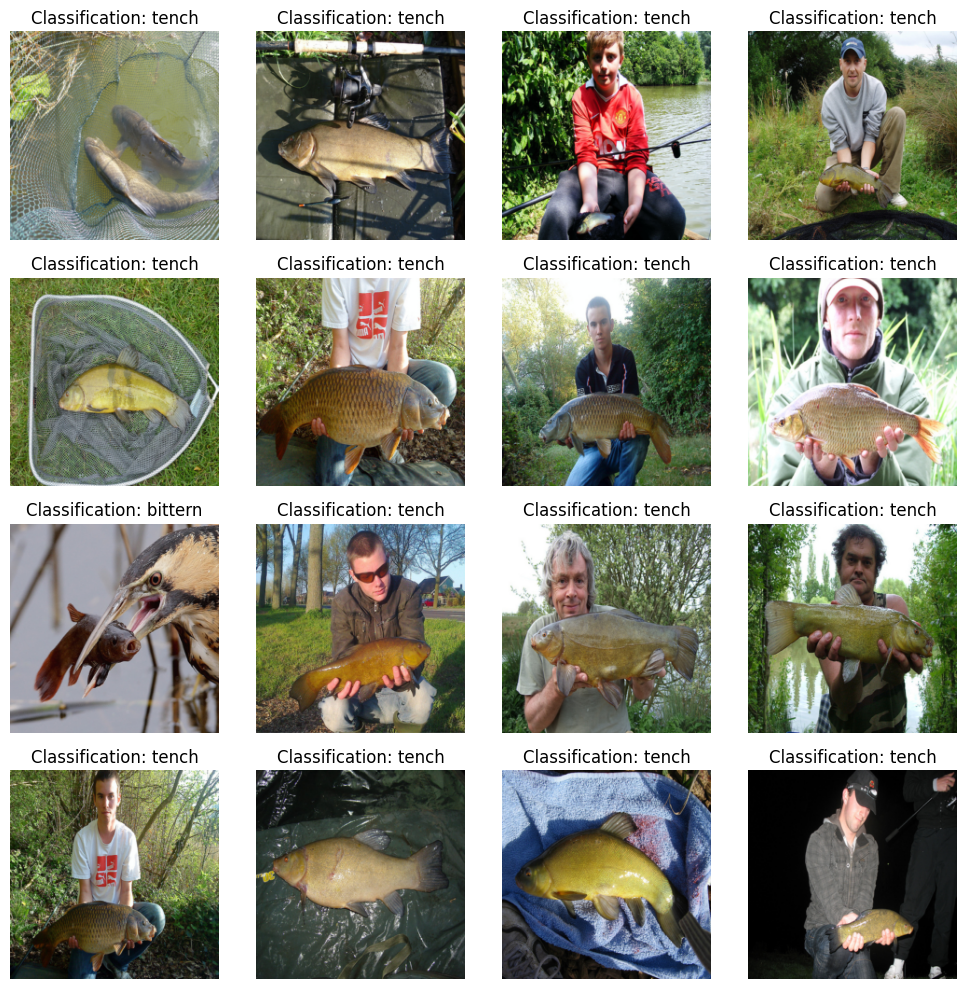

In [479]:
viewBatch(model, inputs, normalize)

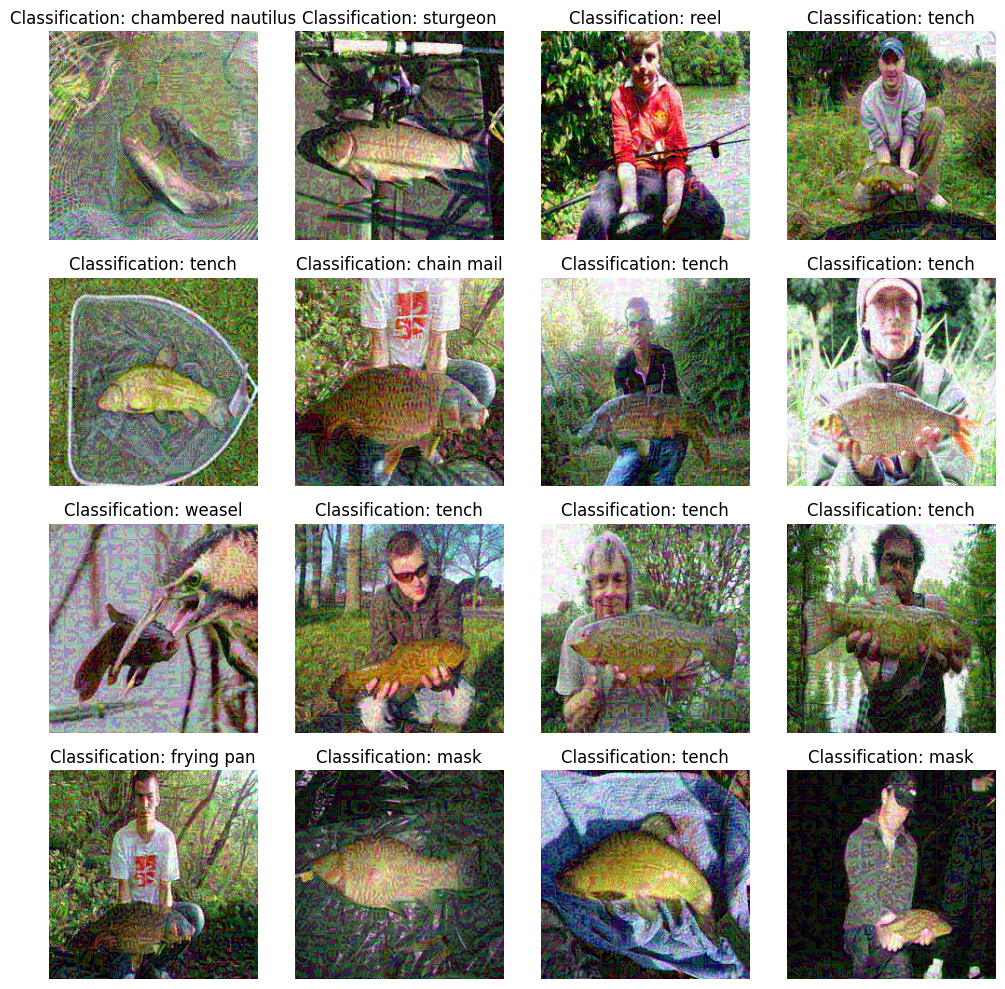

In [480]:
viewBatch(model, adversarialBatch, normalize)

# Adversarial Dataset Builder

In [481]:
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

path_adversarial_dataset = "./data_adv"
os.makedirs(path_adversarial_dataset, exist_ok=True)

In [482]:
def calcImageDistanceMetrics(im1, im2):
    # L-infinity
    linf = torch.norm(im1 - im2, p=float('inf')).item()
    # SSIM and MSE
    im1 = im1.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    im2 = im2.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    mse = mean_squared_error(im1, im2)
    ssim_val = ssim(im1, im2, data_range=(im2.max() - im2.min()), multichannel=True, channel_axis=2)
    return mse, ssim_val, linf

In [483]:
# Saving as Image and Re-loading causes small loss +-0.001, but that is enough to cause the attack to fail
# As such, we save the tensors and load them as a dataset.

def saveImageTensor(tensor, path, label, fname):
    # Ensure directory exists
    dir = f"{path}/{label.item()}"
    os.makedirs(dir, exist_ok=True)
    torch.save(tensor, f"{dir}/{fname}.pt")

MinParamPertubation only works with batchsize one (to find individual minimumpertubations, rather than one for the batch granualarity):
https://captum.ai/api/_modules/captum/robust/_core/metrics/min_param_perturbation.html#MinParamPerturbation.evaluate

In [484]:
dataLoader = torch.utils.data.DataLoader(dataIN,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

# Define preproc function to clip tensors to valid range for image
#preproc_fn = lambda x: torch.clamp(x, 0, 1)

min_pert = MinParamPerturbation(
                                forward_func = lambda *args, **kwargs: model(*args, **kwargs).logits,
                                attack = fgsmAttack,
                                arg_name = 'epsilon',
                                mode = "binary",
                                arg_min = 0.001,
                                arg_max = 0.7,
                                arg_step = 0.001,
                                preproc_fn = normalize,
                                apply_before_preproc=True
                               )

alt_im, min_eps, inputs = None, None, None

log = []

for i, (input, label) in enumerate(dataLoader):
    input = input.to(device)
    label = label.to(device)

    prediction = pred(input, model)

    if prediction == label:
        # We only care for adversarial examples in the case when the model could correctly predict otherwise
        attack_kwargs={'model':model,'true_label':label}

        alt_im, min_eps = min_pert.evaluate(input, attack_kwargs=attack_kwargs, target=label)

        altpred = pred(alt_im, model)
        print(f"adv_{i} is a {model.config.id2label[label.item()]} but classifies as {model.config.id2label[altpred.item()]} with epsilon {min_eps}")

        mse, ssim_val, linf = calcImageDistanceMetrics(input, alt_im)
        log.append({"index": i, "label": label.item(), "prediction": altpred.item(), "epsilon": min_eps, "mse": mse, "ssim": ssim_val, "linf": linf})

        # Save the adversarial example to new dataset
        saveImageTensor(alt_im, path_adversarial_dataset, label, f"adv_{i}")
    else:
        print(f"Incorrect classification, label: {label}, prediction: {prediction}, skipping...")


adv_0 is a tench, Tinca tinca but classifies as hammerhead, hammerhead shark with epsilon 0.001
(224, 224, 3) (224, 224, 3)


In [488]:
# pickle the log
import pickle
with open("data_adv/log.pkl", "wb") as f:
    pickle.dump(log, f)

# Load and Verify Attack

In [485]:
# Load tensor dataset from saved files
loader = lambda x: torch.load(x).squeeze(0)
dataIN2 = datasets.DatasetFolder('./data_adv', loader=loader, extensions=('.pt',))

dataLoader = torch.utils.data.DataLoader(dataIN2,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=0)



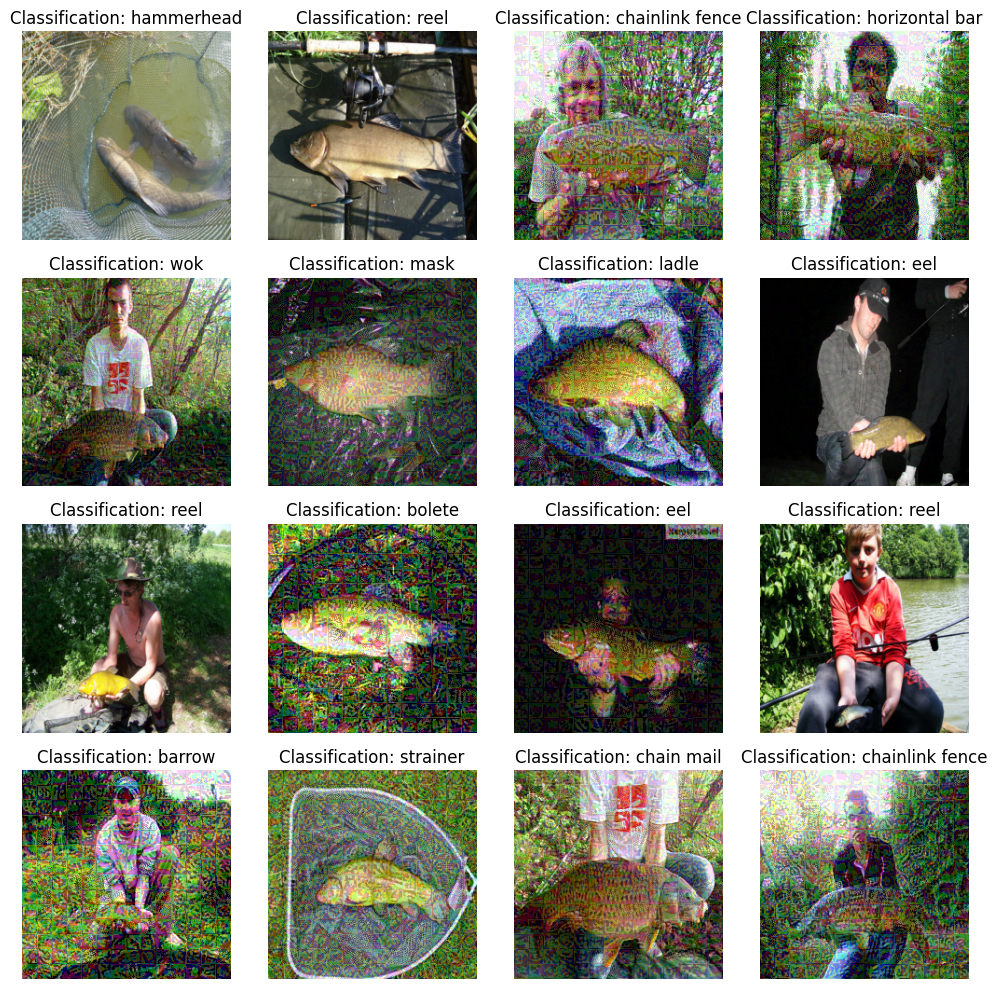

In [486]:
for inputs, labels in dataLoader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    viewBatch(model, inputs, normalize)
    break